The model used uses a Transformer Encoder-based architecture inspired by the ClimaX model.

In [34]:
!pip install prophet sklearn matplotlib pandas numpy openpyxl
# Install ERA5 and other necessary packages
!pip install cdsapi xarray netcdf4 pandas numpy scikit-learn matplotlib seaborn plotly cfgrib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


***ERA5 DATA DOWNLOAD***

In [35]:
with open("/root/.cdsapirc", "w") as f:
    f.write("url: https://cds.climate.copernicus.eu/api/v2\n")
    f.write("key: ")
import os

# Enter your CDS API key here
# You can get an API key from https://cds.climate.copernicus.eu/api-how-to
CDS_API_KEY = ""  # Enter your API key here

# Create .cdsapirc file
cdsapi_config = f"""url: https://cds.climate.copernicus.eu/api
key: {CDS_API_KEY}"""

with open(os.path.expanduser('~/.cdsapirc'), 'w') as f:
    f.write(cdsapi_config)

print("🔑 CDS API configuration completed!")
print("📋 Note: You can get your API key from https://cds.climate.copernicus.eu/api-how-to")


import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import cdsapi
import xarray as xr
import warnings
import os
from google.colab import drive

warnings.filterwarnings('ignore')

class ERA5WeatherDataProcessor:
    def __init__(self, latitude=39.95, longitude=32.85):
        self.latitude = latitude
        self.longitude = longitude
        self.client = cdsapi.Client()

    def fetch_era5_data(self, start_date, end_date):
        """Fetch ERA5 reanalysis data for the specified period (UTC 06:00 for 09:00 Turkey time)"""
        print(f"📡 Fetching ERA5 reanalysis data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")

        # ERA5 single-level dataset
        dataset_name = 'reanalysis-era5-single-levels'

        # Generate list of days within the date range
        days = [(start_date + timedelta(days=x)).day for x in range((end_date - start_date).days + 1)]
        months = list(set([(start_date + timedelta(days=x)).month for x in range((end_date - start_date).days + 1)]))
        years = list(set([(start_date + timedelta(days=x)).year for x in range((end_date - start_date).days + 1)]))

        request_params = {
            'product_type': 'reanalysis',
            'variable': [
                '2m_temperature',           # t2m
                '2m_dewpoint_temperature',  # d2m
                '10m_u_component_of_wind',  # u10
                '10m_v_component_of_wind',  # v10
                'mean_sea_level_pressure',  # msl
                'surface_pressure',        # sp
            ],
            'year': [str(year) for year in years],
            'month': [f"{month:02d}" for month in months],
            'day': [f"{day:02d}" for day in days],
            'time': '06:00',  # UTC 06:00, corresponds to 09:00 Turkey time
            'area': [
                self.latitude + 0.25,    # North
                self.longitude - 0.25,   # West
                self.latitude - 0.25,    # South
                self.longitude + 0.25,   # East
            ],
            'format': 'netcdf',
        }

        # Download data
        temp_file = 'era5_temp_last_30_days.nc'
        try:
            print(f"📥 Downloading: {temp_file}")
            self.client.retrieve(dataset_name, request_params, temp_file)

            # Read NetCDF file
            ds = xr.open_dataset(temp_file)
            print(f"📋 NetCDF variables: {list(ds.variables.keys())}")

            # Select nearest grid point
            ds_point = ds.sel(latitude=self.latitude, longitude=self.longitude, method='nearest')

            # Convert to DataFrame
            df = ds_point.to_dataframe().reset_index()

            # Standardize time column
            if 'valid_time' in df.columns:
                df.rename(columns={'valid_time': 'time'}, inplace=True)
            elif 'time' not in df.columns:
                datetime_cols = df.select_dtypes(include=['datetime64']).columns
                if len(datetime_cols) > 0:
                    df.rename(columns={datetime_cols[0]: 'time'}, inplace=True)

            print(f"📊 Columns: {list(df.columns)}")
            print(f"📏 Data size: {df.shape}")

            # Drop unnecessary columns
            columns_to_drop = ['number', 'expver', 'latitude', 'longitude']
            df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

            # Close and remove NetCDF file
            ds.close()
            if os.path.exists(temp_file):
                os.remove(temp_file)

            return df

        except Exception as e:
            print(f"❌ Failed to fetch data: {e}")
            if os.path.exists(temp_file):
                os.remove(temp_file)
            raise ValueError("❌ Data fetching failed!")

    def clean_data(self, df):
        """Clean the data"""
        print("🧹 Cleaning ERA5 data...")

        # Ensure time column is datetime
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])

        # Check for missing values
        missing_values = df.isna().sum()
        print(f"🔍 Missing values:\n{missing_values}")

        # Interpolate only if there are missing values in numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if df[numeric_cols].isna().any().any():
            print("🔄 Interpolating missing values with linear method...")
            df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')
        else:
            print("✅ No missing values found, skipping interpolation.")

        # Outlier treatment
        for col in numeric_cols:
            if col in df.columns and not df[col].isna().all():
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                median_val = df[col].median()
                df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = median_val

        return df

    def feature_engineering(self, df):
        """Perform feature engineering for the model"""
        print("⚙️ Performing feature engineering for ERA5...")

        # Rename ERA5 variables to standard names
        column_mapping = {
            't2m': 'temperature_2m',
            'd2m': 'dewpoint_2m',
            'u10': 'u_wind_10m',
            'v10': 'v_wind_10m',
            'msl': 'pressure_msl',
            'sp': 'surface_pressure'
        }
        df.rename(columns=column_mapping, inplace=True)

        # Convert temperature to Celsius (from Kelvin)
        if 'temperature_2m' in df.columns:
            df['temperature_2m'] = df['temperature_2m'] - 273.15

        # Convert dewpoint to Celsius and calculate relative humidity
        if 'dewpoint_2m' in df.columns:
            df['dewpoint_2m'] = df['dewpoint_2m'] - 273.15
            def calc_vapor_pressure(temp):
                return 6.112 * np.exp((17.67 * temp) / (temp + 243.5))
            es = calc_vapor_pressure(df['temperature_2m'])  # Saturated vapor pressure
            e = calc_vapor_pressure(df['dewpoint_2m'])      # Actual vapor pressure
            df['relative_humidity_2m'] = (e / es) * 100
            df['relative_humidity_2m'] = df['relative_humidity_2m'].clip(0, 100)

        # Calculate wind speed and direction
        if 'u_wind_10m' in df.columns and 'v_wind_10m' in df.columns:
            df['windspeed_10m'] = np.sqrt(df['u_wind_10m']**2 + df['v_wind_10m']**2)
            df['winddirection_10m'] = np.degrees(np.arctan2(df['v_wind_10m'], df['u_wind_10m'])) % 360

        # Convert pressure from Pa to hPa
        if 'pressure_msl' in df.columns:
            df['pressure_msl'] = df['pressure_msl'] / 100
        if 'surface_pressure' in df.columns:
            df['surface_pressure'] = df['surface_pressure'] / 100

        # Model-specific target columns
        if 'temperature_2m' in df.columns:
            df['temp_fc'] = df['temperature_2m']
            df['temp_p10'] = df['temp_fc'].rolling(14, min_periods=1).quantile(0.1)
            df['temp_p90'] = df['temp_fc'].rolling(14, min_periods=1).quantile(0.9)

        if 'relative_humidity_2m' in df.columns:
            df['rhum_fc'] = df['relative_humidity_2m']
            df['rhum_p10'] = df['rhum_fc'].rolling(14, min_periods=1).quantile(0.1)
            df['rhum_p90'] = df['rhum_fc'].rolling(14, min_periods=1).quantile(0.9)

        if 'windspeed_10m' in df.columns:
            df['wspd_fc'] = df['windspeed_10m']
            df['wspd_p10'] = df['wspd_fc'].rolling(14, min_periods=1).quantile(0.1)
            df['wspd_p90'] = df['wspd_fc'].rolling(14, min_periods=1).quantile(0.9)

        if 'winddirection_10m' in df.columns:
            df['wdir'] = df['winddirection_10m']
            df['wdir_sin'] = np.sin(np.deg2rad(df['wdir']))
            df['wdir_cos'] = np.cos(np.deg2rad(df['wdir']))

        if 'pressure_msl' in df.columns:
            df['pres_fc'] = df['pressure_msl']
            df['pres_p10'] = df['pres_fc'].rolling(14, min_periods=1).quantile(0.1)
            df['pres_p90'] = df['pres_fc'].rolling(14, min_periods=1).quantile(0.9)

        if 'surface_pressure' in df.columns:
            elevation = 770  # Approximate elevation for Ankara (meters)
            df['station_pres'] = df['surface_pressure']
            df['station_p10'] = df['station_pres'].rolling(14, min_periods=1).quantile(0.1)
            df['station_p90'] = df['station_pres'].rolling(14, min_periods=1).quantile(0.9)

        # Time-based features
        df['month'] = df['time'].dt.month
        df['day_of_year'] = df['time'].dt.dayofyear
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

        # Keep only required columns
        columns_to_keep = [
            'time', 'temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'winddirection_10m',
            'pressure_msl', 'surface_pressure', 'month', 'day_of_year', 'month_sin', 'month_cos',
            'day_sin', 'day_cos', 'temp_p10', 'temp_fc', 'temp_p90', 'rhum_p10', 'rhum_fc',
            'rhum_p90', 'wspd_p10', 'wspd_fc', 'wspd_p90', 'wdir', 'pres_p10', 'pres_fc',
            'pres_p90', 'station_p10', 'station_pres', 'station_p90'
        ]
        df = df[[col for col in columns_to_keep if col in df.columns]]

        print(f"✅ Feature engineering completed. Number of columns: {df.shape[1]}")
        return df

    def prepare_patchtst_data(self, df, target_cols):
        """Prepare data for PatchTST"""
        print("📊 Preparing ERA5 data for PatchTST...")
        df_clean = df.reset_index()
        df_clean.rename(columns={'time': 'date'}, inplace=True)
        df_clean = df_clean.dropna()

        # Column ordering: features + targets
        feature_cols = [col for col in df_clean.columns if col not in target_cols + ['date']]
        cols = ['date'] + feature_cols + target_cols
        df_clean = df_clean[cols]

        return df_clean

def main_era5_pipeline():
    """Main pipeline for ERA5 data (last 30 days)"""
    # Set dates (last 30 days, accounting for ERA5 latency)
    latest_available_date = datetime(2025, 8, 15)  # Latest available date per error message
    end_date = latest_available_date
    start_date = end_date - timedelta(days=1825)   # 2025-07-10 to 2025-08-09

    print(f"📅 Data retrieval period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    # 1. Initialize ERA5 Data Processor
    processor = ERA5WeatherDataProcessor(latitude=39.95, longitude=32.85)

    # 2. Fetch Data
    df_raw = processor.fetch_era5_data(start_date, end_date)
    print(f"✅ Fetched {len(df_raw)} days of ERA5 data")
    print(f"📊 Raw data columns: {list(df_raw.columns)}")

    # 3. Clean Data
    df_clean = processor.clean_data(df_raw)
    print(f"📊 Cleaned data columns: {list(df_clean.columns)}")

    # 4. Feature Engineering
    df_features = processor.feature_engineering(df_clean)
    print(f"📊 Feature columns: {list(df_features.columns)}")

    # 5. Prepare for PatchTST
    target_cols = ['temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres']
    df_final = processor.prepare_patchtst_data(df_features, target_cols)

    print(f"🎯 ERA5 Final dataset shape: {df_final.shape}")
    print(f"📋 Final columns: {list(df_final.columns)}")

    # 6. Save to CSV
    output_file = "era5_last_30_days.csv"
    df_final.to_csv(output_file, index=False)
    print(f"💾 ERA5 data saved: {output_file}")

    # 8. Display first few rows
    print("\n📋 First 5 rows:")
    print(df_final.head())

    return df_final, output_file

if __name__ == "__main__":
    print("🌍 ERA5 LAST 30 DAYS WEATHER DATA PROCESSING SYSTEM")
    print("="*55)

    # Check CDS API installation
    try:
        import cdsapi
        print("✅ CDS API installed")
    except ImportError:
        print("❌ CDS API not installed. Install using: pip install cdsapi")
        print("📖 Also ensure your API key is set in ~/.cdsapirc")
        exit(1)

    # Run the pipeline
    df_final, output_file = main_era5_pipeline()

🔑 CDS API configuration completed!
📋 Note: You can get your API key from https://cds.climate.copernicus.eu/api-how-to
🌍 ERA5 LAST 30 DAYS WEATHER DATA PROCESSING SYSTEM
✅ CDS API installed
📅 Data retrieval period: 2020-08-16 to 2025-08-15


2025-12-27 21:02:02,419 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


📡 Fetching ERA5 reanalysis data from 2020-08-16 to 2025-08-15...
📥 Downloading: era5_temp_last_30_days.nc


2025-12-27 21:02:11,737 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
INFO:ecmwf.datastores.legacy_client:[2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
2025-

c416ef8b4bd1c4d1b7a5c17c33d2346.nc:   0%|          | 0.00/506k [00:00<?, ?B/s]

📋 NetCDF variables: ['t2m', 'd2m', 'u10', 'v10', 'msl', 'sp', 'number', 'valid_time', 'latitude', 'longitude', 'expver']
📊 Columns: ['time', 't2m', 'd2m', 'u10', 'v10', 'msl', 'sp', 'number', 'latitude', 'longitude', 'expver']
📏 Data size: (2183, 11)
✅ Fetched 2183 days of ERA5 data
📊 Raw data columns: ['time', 't2m', 'd2m', 'u10', 'v10', 'msl', 'sp']
🧹 Cleaning ERA5 data...
🔍 Missing values:
time    0
t2m     0
d2m     0
u10     0
v10     0
msl     0
sp      0
dtype: int64
✅ No missing values found, skipping interpolation.
📊 Cleaned data columns: ['time', 't2m', 'd2m', 'u10', 'v10', 'msl', 'sp']
⚙️ Performing feature engineering for ERA5...
✅ Feature engineering completed. Number of columns: 29
📊 Feature columns: ['time', 'temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'winddirection_10m', 'pressure_msl', 'surface_pressure', 'month', 'day_of_year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'temp_p10', 'temp_fc', 'temp_p90', 'rhum_p10', 'rhum_fc', 'rhum_p90', 'wspd_p10

In [36]:
!ls
from google.colab import files
files.download('era5_last_30_days.csv')

climax_forecast_adjusted.xls  model_evaluation.png   sample_data
era5_last_30_days.csv	      model_metrics.xlsx     time_series_evaluation.png
error_distribution.png	      residual_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MODEL TRAIN AND TEST R2

First 5 Rows of Dataset:
                 date  index  temperature_2m  relative_humidity_2m  \
0 2020-01-01 06:00:00      0        2.502167              95.17330   
1 2020-01-02 06:00:00      1        0.184113              73.11352   
2 2020-01-03 06:00:00      2       -1.471466              81.67258   
3 2020-01-04 06:00:00      3       -1.706329              84.49988   
4 2020-01-05 06:00:00      4       -3.039795              91.99368   

   windspeed_10m  winddirection_10m  pressure_msl  surface_pressure  month  \
0       2.541201          18.217985    1019.52563         889.08470      1   
1       2.882674         235.758620    1024.11170         892.14935      1   
2       3.316990         223.733060    1024.58390         892.25940      1   
3       1.415756          44.404580    1018.14780         887.07690      1   
4       1.080241          53.768272    1017.41250         886.29220      1   

   day_of_year  ...        wdir     pres_p10     pres_p90  station_p10  \
0          

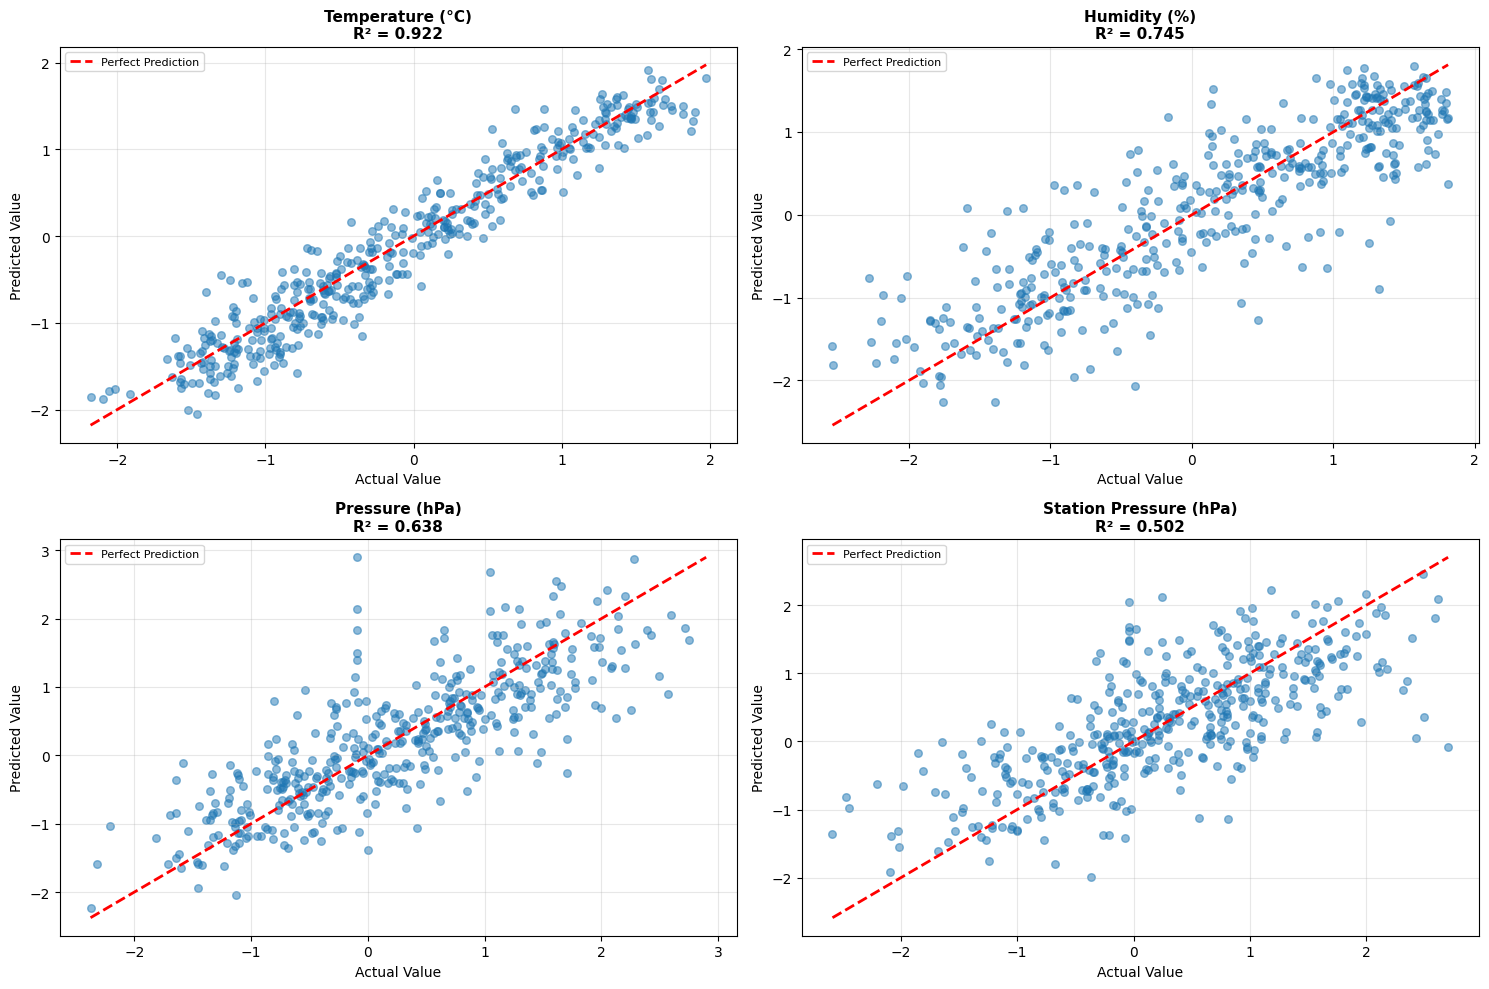


Plot saved: model_evaluation.png


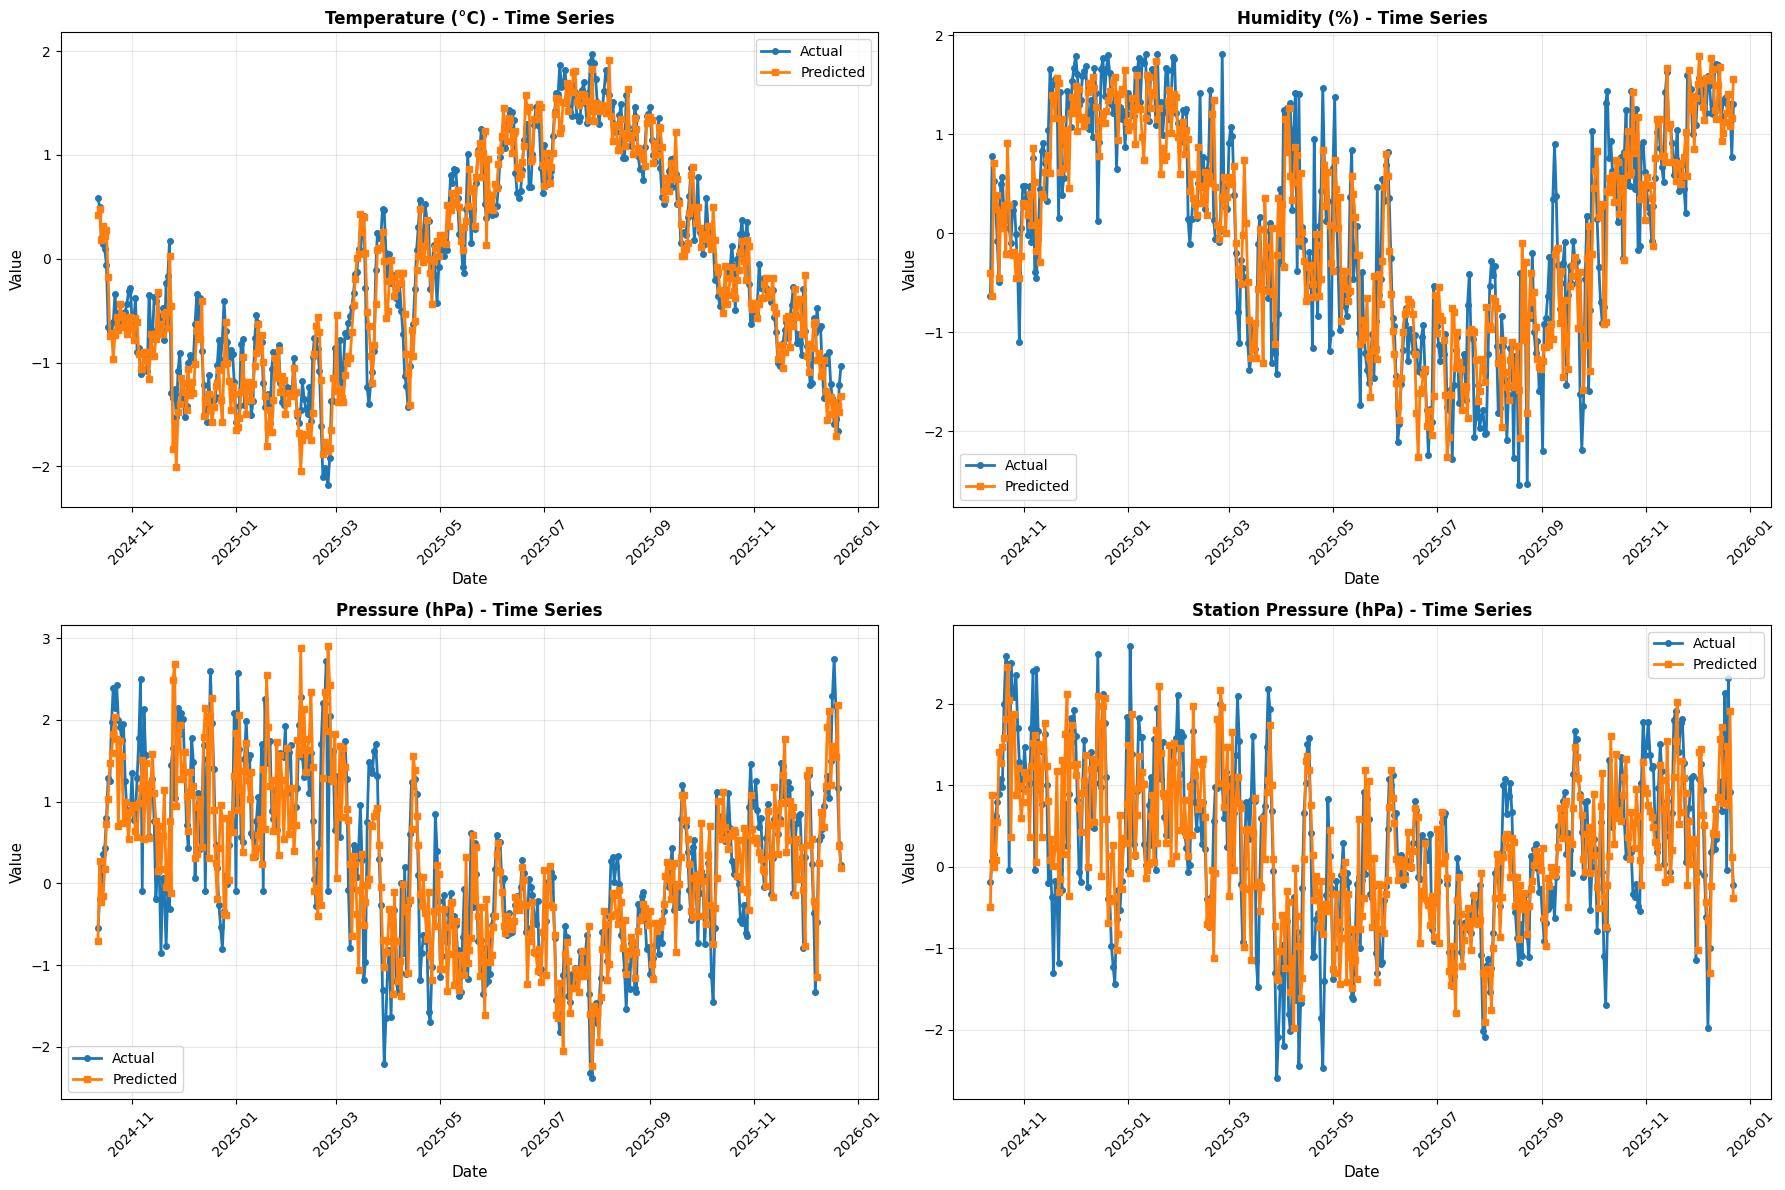

Time series plots saved: time_series_evaluation.png


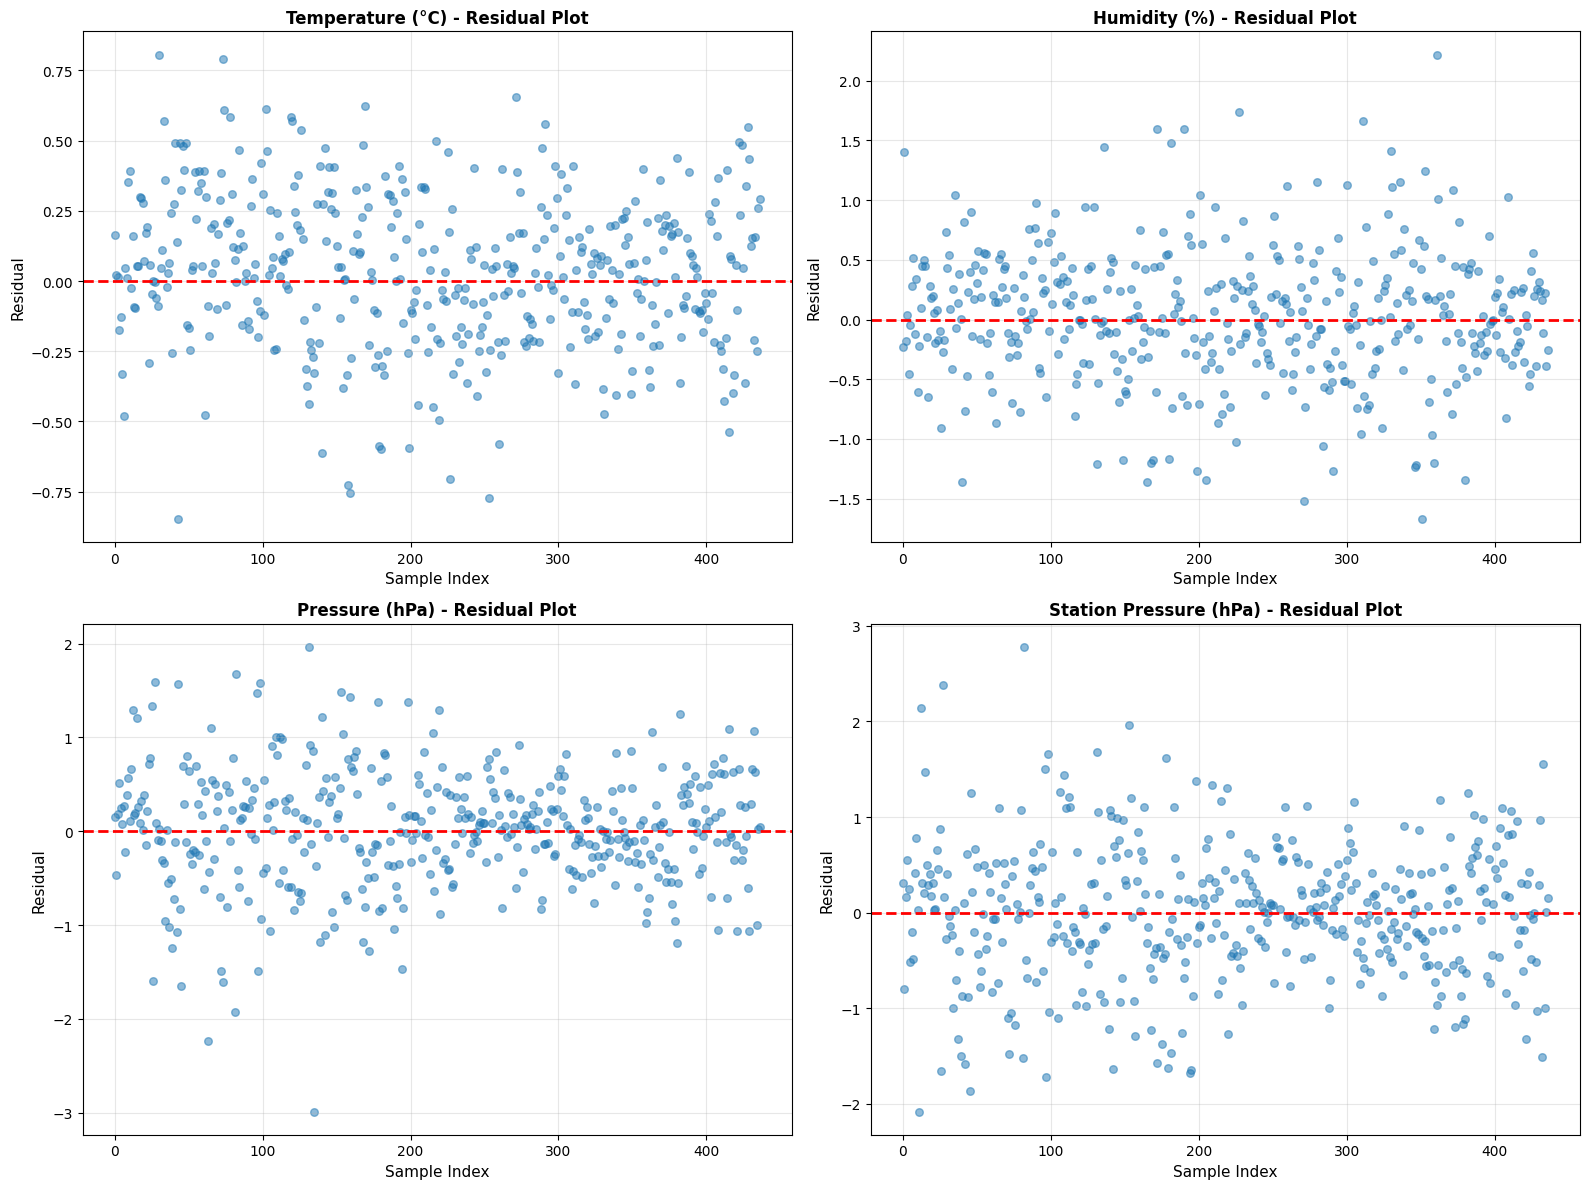

Residual analysis plots saved: residual_analysis.png


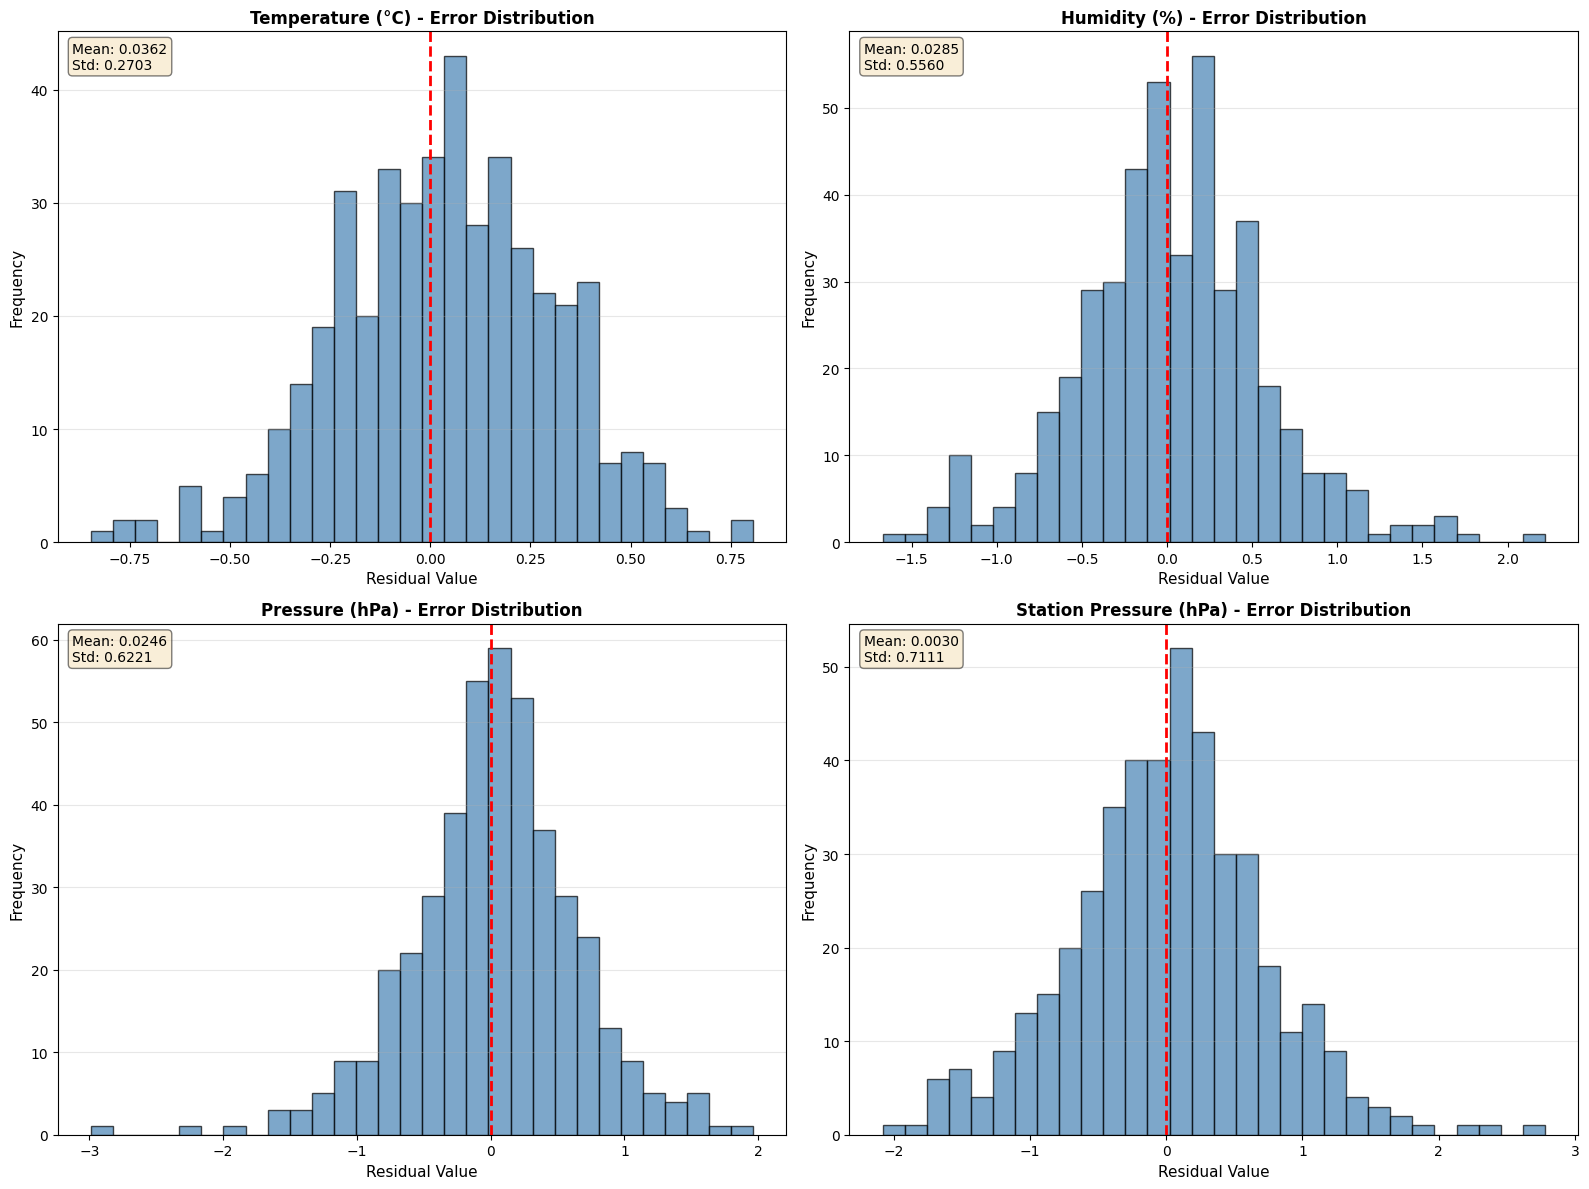

Error distribution plots saved: error_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


EVALUATION COMPLETED!

Saved files:
1. model_evaluation.png - Actual vs Predicted plots
2. time_series_evaluation.png - Time series prediction plots
3. residual_analysis.png - Residual analysis
4. error_distribution.png - Error distribution histograms
5. model_metrics.xlsx - Detailed metrics


In [37]:
# CLIMAX METHOD - MODEL EVALUATION
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Load dataset from Colab environment
data_path = '/content/era5_last_30_days.csv'
data = pd.read_csv(data_path)

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

print("First 5 Rows of Dataset:")
print(data.head())
print(f"\nTotal data points: {len(data)}")

# ClimaX-like transformer model definition
class ClimaXWeatherModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=6, num_heads=8, output_dim=7, dropout=0.1):
        super(ClimaXWeatherModel, self).__init__()

        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1000, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output heads for each weather variable
        self.temp_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.rhum_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.wspd_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.pres_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.station_pres_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.wdir_sin_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.wdir_cos_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        x = self.input_projection(x)
        x = x + self.pos_encoding[:seq_len].unsqueeze(0).repeat(batch_size, 1, 1)
        x = self.transformer(x)
        x = x[:, -1, :]
        x = self.dropout(x)

        return {
            'temp': self.temp_head(x),
            'rhum': self.rhum_head(x),
            'wspd': self.wspd_head(x),
            'pres': self.pres_head(x),
            'station_pres': self.station_pres_head(x),
            'wdir_sin': self.wdir_sin_head(x),
            'wdir_cos': self.wdir_cos_head(x)
        }

# Dataset class
class WeatherDataset(Dataset):
    def __init__(self, data, sequence_length=14, target_vars=None):
        self.sequence_length = sequence_length
        self.data = data
        self.target_vars = target_vars or [
            'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc',
            'station_pres', 'wdir_sin', 'wdir_cos'
        ]

        self.feature_cols = [
            'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres',
            'wdir_sin', 'wdir_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
        ]

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx:idx + self.sequence_length][self.feature_cols].values.astype(np.float32)
        targets = self.data.iloc[idx + self.sequence_length][self.target_vars].values.astype(np.float32)
        return torch.FloatTensor(sequence), torch.FloatTensor(targets)

# Data preprocessing
data['wdir_sin'] = np.sin(np.radians(data['winddirection_10m']))
data['wdir_cos'] = np.cos(np.radians(data['winddirection_10m']))

if 'month_sin' not in data.columns:
    data['month'] = data['date'].dt.month
    data['day_of_year'] = data['date'].dt.dayofyear
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)

data = data.sort_values('date').reset_index(drop=True)
data = data.fillna(method='ffill').fillna(method='bfill')

# Feature columns
feature_cols = [
    'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres',
    'wdir_sin', 'wdir_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
]

# Normalization
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Train/Test Split (80/20)
sequence_length = 14
target_vars = ['temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres', 'wdir_sin', 'wdir_cos']

train_size = int(len(data) * 0.8)
train_data = data[:train_size].copy()
test_data = data[train_size-sequence_length:].copy()

print(f"\nTrain data: {len(train_data)} days")
print(f"Test data: {len(test_data)-sequence_length} days")

# DataLoaders
train_dataset = WeatherDataset(train_data, sequence_length, target_vars)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = WeatherDataset(test_data, sequence_length, target_vars)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice used: {device}")

model = ClimaXWeatherModel(
    input_dim=len(feature_cols),
    hidden_dim=128,
    num_layers=4,
    num_heads=8,
    output_dim=len(target_vars),
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Model training
print("\n" + "="*50)
print("MODEL TRAINING STARTED")
print("="*50)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0

    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)

        loss = 0
        for i, var in enumerate(['temp', 'rhum', 'wspd', 'pres', 'station_pres', 'wdir_sin', 'wdir_cos']):
            pred = outputs[var].squeeze()
            target_val = targets[:, i]
            loss += criterion(pred, target_val)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)

            loss = 0
            for i, var in enumerate(['temp', 'rhum', 'wspd', 'pres', 'station_pres', 'wdir_sin', 'wdir_cos']):
                pred = outputs[var].squeeze()
                target_val = targets[:, i]
                loss += criterion(pred, target_val)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("\nModel training completed!")

# Model Evaluation
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

model.eval()
all_predictions = {var: [] for var in target_vars}
all_targets = {var: [] for var in target_vars}

with torch.no_grad():
    for sequences, targets in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)

        for i, var_key in enumerate(['temp', 'rhum', 'wspd', 'pres', 'station_pres', 'wdir_sin', 'wdir_cos']):
            pred = outputs[var_key].cpu().numpy().squeeze()
            target = targets[:, i].numpy()

            all_predictions[target_vars[i]].extend(pred)
            all_targets[target_vars[i]].extend(target)

# Calculate metrics
print("\nEVALUATION METRICS:")
print("-" * 80)
print(f"{'Variable':<20} {'MAE':<12} {'RMSE':<12} {'R² Score':<12}")
print("-" * 80)

metrics_results = {}
for var in target_vars:
    y_true = np.array(all_targets[var])
    y_pred = np.array(all_predictions[var])

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    metrics_results[var] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{var:<20} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f}")

print("-" * 80)

# Visualizations
fig = plt.figure(figsize=(15, 10))

# Variable names for display
var_names = {
    'temp_fc': 'Temperature (°C)',
    'rhum_fc': 'Humidity (%)',
    'pres_fc': 'Pressure (hPa)',
    'station_pres': 'Station Pressure (hPa)'
}

# Only selected variables (removed wind speed and wind direction components)
selected_vars = ['temp_fc', 'rhum_fc', 'pres_fc', 'station_pres']

for idx, var in enumerate(selected_vars, start=1):
    plt.subplot(2, 2, idx)
    y_true = np.array(all_targets[var])
    y_pred = np.array(all_predictions[var])

    plt.scatter(y_true, y_pred, alpha=0.5, s=30)

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.xlabel('Actual Value', fontsize=10)
    plt.ylabel('Predicted Value', fontsize=10)
    plt.title(f'{var_names[var]}\nR² = {metrics_results[var]["R2"]:.3f}', fontsize=11, fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved: model_evaluation.png")

# Time series prediction plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

test_dates = data.iloc[train_size:train_size + len(all_targets['temp_fc'])]['date'].values

for idx, var in enumerate(selected_vars):
    y_true = np.array(all_targets[var])
    y_pred = np.array(all_predictions[var])

    axes[idx].plot(test_dates, y_true, label='Actual', linewidth=2, marker='o', markersize=4)
    axes[idx].plot(test_dates, y_pred, label='Predicted', linewidth=2, marker='s', markersize=4)
    axes[idx].set_xlabel('Date', fontsize=11)
    axes[idx].set_ylabel('Value', fontsize=11)
    axes[idx].set_title(f'{var_names[var]} - Time Series', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/content/time_series_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Time series plots saved: time_series_evaluation.png")

# Additional analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Residual plots for each variable
for idx, var in enumerate(selected_vars):
    y_true = np.array(all_targets[var])
    y_pred = np.array(all_predictions[var])
    residuals = y_true - y_pred

    axes[idx].scatter(range(len(residuals)), residuals, alpha=0.5, s=30)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Sample Index', fontsize=11)
    axes[idx].set_ylabel('Residual', fontsize=11)
    axes[idx].set_title(f'{var_names[var]} - Residual Plot', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual analysis plots saved: residual_analysis.png")

# Error distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    y_true = np.array(all_targets[var])
    y_pred = np.array(all_predictions[var])
    residuals = y_true - y_pred

    axes[idx].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Residual Value', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{var_names[var]} - Error Distribution', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add statistics text
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[idx].text(0.02, 0.98, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}',
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Error distribution plots saved: error_distribution.png")

# Save results to Excel
results_df = pd.DataFrame(metrics_results).T
results_df.to_excel('/content/model_metrics.xlsx', index=True)
files.download('/content/model_metrics.xlsx')

print("\n" + "="*50)
print("EVALUATION COMPLETED!")
print("="*50)
print("\nSaved files:")
print("1. model_evaluation.png - Actual vs Predicted plots")
print("2. time_series_evaluation.png - Time series prediction plots")
print("3. residual_analysis.png - Residual analysis")
print("4. error_distribution.png - Error distribution histograms")
print("5. model_metrics.xlsx - Detailed metrics")

**MODEL TRAIN AND TEST FOR NEXT 30 DAYS**

In [38]:
# CLIMAX METHOD
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Google Drive connection removed. To read data from the Colab environment,
# you must upload the 'era5_last_30_days.csv' file to Colab's '/content/' directory.
# You can upload the file using the files.upload() command, or drag and drop it from the file icon in the left panel.

# Read the dataset from the Colab environment
data_path = '/content/era5_last_30_days.csv'  # The file must be in Colab's '/content/' directory
data = pd.read_csv(data_path)

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Check the dataset
print("First 5 Rows of the Dataset:")
print(data.head())


# ClimaX-like transformer model definition
class ClimaXWeatherModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=6, num_heads=8, output_dim=7, dropout=0.1):
        super(ClimaXWeatherModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1000, hidden_dim))

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output heads for each weather variable
        self.temp_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)  # mean, lower, upper
        )

        self.rhum_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.wspd_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.pres_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.station_pres_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.wdir_sin_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.wdir_cos_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Input projection
        x = self.input_projection(x)

        # Add positional encoding
        x = x + self.pos_encoding[:seq_len].unsqueeze(0).repeat(batch_size, 1, 1)

        # Transformer
        x = self.transformer(x)

        # Use last timestep for prediction
        x = x[:, -1, :]  # Take last timestep
        x = self.dropout(x)

        # Multi-head predictions
        temp_pred = self.temp_head(x)
        rhum_pred = self.rhum_head(x)
        wspd_pred = self.wspd_head(x)
        pres_pred = self.pres_head(x)
        station_pres_pred = self.station_pres_head(x)
        wdir_sin_pred = self.wdir_sin_head(x)
        wdir_cos_pred = self.wdir_cos_head(x)

        return {
            'temp': temp_pred,
            'rhum': rhum_pred,
            'wspd': wspd_pred,
            'pres': pres_pred,
            'station_pres': station_pres_pred,
            'wdir_sin': wdir_sin_pred,
            'wdir_cos': wdir_cos_pred
        }

# Dataset class
class WeatherDataset(Dataset):
    def __init__(self, data, sequence_length=14, target_vars=None):
        self.sequence_length = sequence_length
        self.data = data
        self.target_vars = target_vars or [
            'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc',
            'station_pres', 'wdir_sin', 'wdir_cos'
        ]

        # Feature columns
        self.feature_cols = [
            'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres',
            'wdir_sin', 'wdir_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
        ]

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Get sequence - ensure we're only selecting numeric columns
        sequence = self.data.iloc[idx:idx + self.sequence_length][self.feature_cols].values.astype(np.float32)

        # Get targets (next timestep) - ensure numeric
        targets = self.data.iloc[idx + self.sequence_length][self.target_vars].values.astype(np.float32)

        return torch.FloatTensor(sequence), torch.FloatTensor(targets)


# Check the dataset
print("First 5 Rows of the Dataset:")
print(data.head())

# Sin/cos transformation for wind direction
data['wdir_sin'] = np.sin(np.radians(data['winddirection_10m']))
data['wdir_cos'] = np.cos(np.radians(data['winddirection_10m']))

# Time-based features (if not already present)
if 'month_sin' not in data.columns:
    data['month'] = data['date'].dt.month
    data['day_of_year'] = data['date'].dt.dayofyear
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['day_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)

# Sort the data
data = data.sort_values('date').reset_index(drop=True)

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Feature normalization
feature_cols = [
    'temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres',
    'wdir_sin', 'wdir_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
]

scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Create Dataset and DataLoader
sequence_length = 14  # Last 2 weeks of data
target_vars = ['temp_fc', 'rhum_fc', 'wspd_fc', 'pres_fc', 'station_pres', 'wdir_sin', 'wdir_cos']

# Training data (excluding last 7 days)
train_data = data[:-7].copy()
train_dataset = WeatherDataset(train_data, sequence_length, target_vars)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test data (last 7 days)
test_data = data[-sequence_length-7:].copy()

# Model and training settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

model = ClimaXWeatherModel(
    input_dim=len(feature_cols),
    hidden_dim=128,  # Smaller model (based on data size)
    num_layers=4,
    num_heads=8,
    output_dim=len(target_vars),
    dropout=0.1
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Model training
print("Model training started...")
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (sequences, targets) in enumerate(train_loader):
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences)

        # Multi-task loss
        loss = 0
        for i, var in enumerate(['temp', 'rhum', 'wspd', 'pres', 'station_pres', 'wdir_sin', 'wdir_cos']):
            pred_mean = outputs[var][:, 0]  # Mean prediction
            target_val = targets[:, i]
            loss += criterion(pred_mean, target_val)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    if (epoch + 1) % 20 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Model training completed!")

# Prediction function
def predict_future(model, data, scaler, days=30):
    model.eval()
    predictions = []

    # Get the last sequence_length data points
    current_sequence = data[-sequence_length:][feature_cols].values
    current_sequence = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)

    last_date = pd.to_datetime(data['date'].iloc[-1])

    with torch.no_grad():
        for day in range(days):
            # Make prediction
            outputs = model(current_sequence)

            # Get predictions
            pred_dict = {}
            for var in ['temp', 'rhum', 'wspd', 'pres', 'station_pres', 'wdir_sin', 'wdir_cos']:
                pred_dict[f'{var}_mean'] = outputs[var][0, 0].item()
                pred_dict[f'{var}_lower'] = outputs[var][0, 0].item() - 1.96 * abs(outputs[var][0, 0].item() * 0.1)  # Simple confidence interval
                pred_dict[f'{var}_upper'] = outputs[var][0, 0].item() + 1.96 * abs(outputs[var][0, 0].item() * 0.1)

            # Future date
            future_date = last_date + pd.Timedelta(days=day+1)
            pred_dict['date'] = future_date

            # Time features
            month = future_date.month
            day_of_year = future_date.dayofyear
            pred_dict['month_sin'] = np.sin(2 * np.pi * month / 12)
            pred_dict['month_cos'] = np.cos(2 * np.pi * month / 12)
            pred_dict['day_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
            pred_dict['day_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

            predictions.append(pred_dict)

            # Update the sequence for the next prediction
            # Add new prediction values to the sequence
            new_features = [
                pred_dict['temp_mean'], pred_dict['rhum_mean'], pred_dict['wspd_mean'],
                pred_dict['pres_mean'], pred_dict['station_pres_mean'],
                pred_dict['wdir_sin_mean'], pred_dict['wdir_cos_mean'],
                pred_dict['month_sin'], pred_dict['month_cos'],
                pred_dict['day_sin'], pred_dict['day_cos']
            ]

            # Normalization (to keep in the same scale as previous data)
            new_features_normalized = new_features  # Predictions are already normalized

            # Shift the sequence and add the new value
            new_timestep = torch.FloatTensor(new_features_normalized).unsqueeze(0).unsqueeze(0).to(device)
            current_sequence = torch.cat([current_sequence[:, 1:, :], new_timestep], dim=1)

    return pd.DataFrame(predictions)

# 30-day forecast is being generated
print("30-day forecast is being generated...")
future_predictions = predict_future(model, data, scaler, days=30)

# Convert predictions to original scale
# Undo normalization
feature_predictions = future_predictions[['temp_mean', 'rhum_mean', 'wspd_mean', 'pres_mean',
                                        'station_pres_mean', 'wdir_sin_mean', 'wdir_cos_mean',
                                        'month_sin', 'month_cos', 'day_sin', 'day_cos']]

# Inverse transform the scaler
original_predictions = scaler.inverse_transform(feature_predictions)

# Put results back into DataFrame
combined_forecast = pd.DataFrame()
combined_forecast['ds'] = future_predictions['date']
combined_forecast['temp_fc'] = original_predictions[:, 0]
combined_forecast['rhum_fc'] = original_predictions[:, 1]
combined_forecast['wspd_fc'] = original_predictions[:, 2]
combined_forecast['pres_fc'] = original_predictions[:, 3]
combined_forecast['station_pres'] = original_predictions[:, 4]

# Confidence intervals (original scale)
temp_std = np.std(data['temp_fc'].iloc[-30:])  # Standard deviation of the last 30 days
combined_forecast['temp_p10'] = combined_forecast['temp_fc'] - 1.96 * temp_std
combined_forecast['temp_p90'] = combined_forecast['temp_fc'] + 1.96 * temp_std

rhum_std = np.std(data['rhum_fc'].iloc[-30:])
combined_forecast['rhum_p10'] = combined_forecast['rhum_fc'] - 1.96 * rhum_std
combined_forecast['rhum_p90'] = combined_forecast['rhum_fc'] + 1.96 * rhum_std

wspd_std = np.std(data['wspd_fc'].iloc[-30:])
combined_forecast['wspd_p10'] = combined_forecast['wspd_fc'] - 1.96 * wspd_std
combined_forecast['wspd_p90'] = combined_forecast['wspd_fc'] + 1.96 * wspd_std

pres_std = np.std(data['pres_fc'].iloc[-30:])
combined_forecast['pres_p10'] = combined_forecast['pres_fc'] - 1.96 * pres_std
combined_forecast['pres_p90'] = combined_forecast['pres_fc'] + 1.96 * pres_std

station_std = np.std(data['station_pres'].iloc[-30:])
combined_forecast['station_p10'] = combined_forecast['station_pres'] - 1.96 * station_std
combined_forecast['station_p90'] = combined_forecast['station_pres'] + 1.96 * station_std

# Calculate wind direction
wdir_sin_orig = original_predictions[:, 5]
wdir_cos_orig = original_predictions[:, 6]
combined_forecast['wdir'] = (np.arctan2(wdir_sin_orig, wdir_cos_orig) * 180 / np.pi) % 360

# Wind direction confidence intervals (simplified)
wdir_std = 15  # Standard deviation in degrees
combined_forecast['wdir_p10'] = (combined_forecast['wdir'] - wdir_std) % 360
combined_forecast['wdir_p90'] = (combined_forecast['wdir'] + wdir_std) % 360

# Altitude correction (for 770 m)
combined_forecast['station_pres'] = combined_forecast['station_pres'] + 32  # 1000 m -> 770 m
combined_forecast['station_p10'] = combined_forecast['station_p10'] + 32
combined_forecast['station_p90'] = combined_forecast['station_p90'] + 32
combined_forecast['temp_fc'] = combined_forecast['temp_fc'] + 0.8  # ~0.6°C increase for every 100 m drop
combined_forecast['temp_p10'] = combined_forecast['temp_p10'] + 0.8
combined_forecast['temp_p90'] = combined_forecast['temp_p90'] + 0.8

# Function to convert degrees to wind direction
def derece_to_yon(derece):
    if (derece >= 348.75) or (derece < 11.25):
        return "North (N)"
    elif derece < 33.75:
        return "North-Northeast (NNE)"
    elif derece < 56.25:
        return "Northeast (NE)"
    elif derece < 78.75:
        return "East-Northeast (ENE)"
    elif derece < 101.25:
        return "East (E)"
    elif derece < 123.75:
        return "East-Southeast (ESE)"
    elif derece < 146.25:
        return "Southeast (SE)"
    elif derece < 168.75:
        return "South-Southeast (SSE)"
    elif derece < 191.25:
        return "South (S)"
    elif derece < 213.75:
        return "South-Southwest (SSW)"
    elif derece < 236.25:
        return "Southwest (SW)"
    elif derece < 258.75:
        return "West-Southwest (WSW)"
    elif derece < 281.25:
        return "West (W)"
    elif derece < 303.75:
        return "West-Northwest (WNW)"
    elif derece < 326.25:
        return "Northwest (NW)"
    elif derece < 348.75:
        return "North-Northwest (NNW)"
    else:
        return "Invalid"

# Add direction texts to Excel output
combined_forecast['Ruzgar_Yon'] = combined_forecast['wdir'].apply(derece_to_yon)

print("Forecast results:")
print(combined_forecast.head())

# Save and download predictions to .xls file
combined_forecast.to_excel('/content/climax_forecast_adjusted.xls', index=False, engine='openpyxl')
files.download('/content/climax_forecast_adjusted.xls')

print("30-day weather forecast with ClimaX model completed!")
print("File 'climax_forecast_adjusted.xls' saved.")

First 5 Rows of the Dataset:
                 date  index  temperature_2m  relative_humidity_2m  \
0 2020-01-01 06:00:00      0        2.502167              95.17330   
1 2020-01-02 06:00:00      1        0.184113              73.11352   
2 2020-01-03 06:00:00      2       -1.471466              81.67258   
3 2020-01-04 06:00:00      3       -1.706329              84.49988   
4 2020-01-05 06:00:00      4       -3.039795              91.99368   

   windspeed_10m  winddirection_10m  pressure_msl  surface_pressure  month  \
0       2.541201          18.217985    1019.52563         889.08470      1   
1       2.882674         235.758620    1024.11170         892.14935      1   
2       3.316990         223.733060    1024.58390         892.25940      1   
3       1.415756          44.404580    1018.14780         887.07690      1   
4       1.080241          53.768272    1017.41250         886.29220      1   

   day_of_year  ...        wdir     pres_p10     pres_p90  station_p10  \
0      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

30-day weather forecast with ClimaX model completed!
File 'climax_forecast_adjusted.xls' saved.


In [39]:
!ls '/content/'

climax_forecast_adjusted.xls  model_evaluation.png   sample_data
era5_last_30_days.csv	      model_metrics.xlsx     time_series_evaluation.png
error_distribution.png	      residual_analysis.png
